In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_4.txt
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/qualifying.txt


## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime,time
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

## Labelling all the Filenames which consist Data

In [2]:
filenames = []
for i in range(1,5):
    filenames.append('/kaggle/input/netflix-prize-data/combined_data_'+str(i)+'.txt')
print(filenames)

['/kaggle/input/netflix-prize-data/combined_data_1.txt', '/kaggle/input/netflix-prize-data/combined_data_2.txt', '/kaggle/input/netflix-prize-data/combined_data_3.txt', '/kaggle/input/netflix-prize-data/combined_data_4.txt']


## Combining all the different files into 1 large File

In [3]:
if not os.path.isfile('data.csv'):

    data = open('data.csv',mode= 'w')
    
    for file in filenames:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line[-1] == ':':
                    movie = line[:-1]
                else:
                    row = [i for i in line.split(',')]
                    row.insert(0,movie)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()
    

### Initalizing a dataframe and sorting the values by 

In [4]:
df = pd.read_csv('data.csv',sep = ',', names = ['movie','user','rating','date'])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by = 'date')

In [6]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [6]:
df.describe()

,movie,user,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


In [6]:
print("Number of Null values in dataframe : ", sum(df.isnull().any()))

Number of Null values in dataframe :  0


In [9]:
print("Number of unique movies: ", len(pd.unique(df['movie'])))

Number of unique movies:  17770


In [10]:
print("Number of unique users: ", len(pd.unique(df['user'])))

Number of unique users:  480189


<AxesSubplot:xlabel='rating', ylabel='count'>

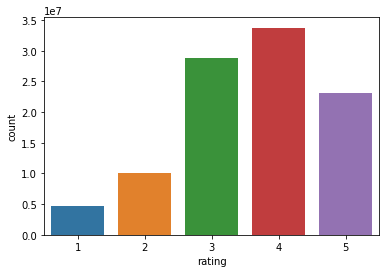

In [7]:
import seaborn as sns
sns.countplot(x=df["rating"])

### Splitting the data into train and test

In [19]:
train_df = df.iloc[:int(len(df)*0.8)]
test_df = df.iloc[int(len(df)*0.8):]
if not os.path.isfile('train.csv'):
    train_df.to_csv('train.csv',index = False)
if not os.path.isfile('test.csv'):
    test_df.to_csv('test.csv',index = False)

### Creating a Sparse matrix of users and movies with values as Rating

In [20]:
if not os.path.isfile('train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.csr_matrix((train_df['rating'].values,(train_df['user'].values,train_df['movie'].values)))
    sparse.save_npz('train_sparse_matrix.npz',train_sparse_matrix)
if not os.path.isfile('test_sparse_matrix.npz'):
    test_sparse_matrix = sparse.csr_matrix((test_df['rating'].values,(test_df['user'].values,test_df['movie'].values)))
    sparse.save_npz('test_sparse_matrix.npz',test_sparse_matrix)

### Calculating the Similarities Between Movies

In [23]:
if not os.path.isfile('mov_mov_sim.npz'):
    s = time.time()
    mov_sim = cosine_similarity(X=train_sparse_matrix.T,dense_output = False)
    e = time.time()
    print('time taken:'+stre-s)
    sparse.save_npz('mov_mov_sim.npz',mov_sim)
else:
    mov_sim = sparse.load_npz('mov_mov_sim.npz')

time taken:291.93383836746216


In [21]:
mov_sim.shape

(17771, 17771)

### Finding similar movies for each movie

In [14]:
mov_ids = np.unique(mov_sim.nonzero()[1])
sim_movies_dic = {}
for m in mov_ids:
    sim_movs = mov_sim[m].toarray().ravel().argsort()[::-1][1:]
    sim_movies_dic[m] = sim_movs[:100]

In [23]:
sim_movies_dic[20]

array([ 6242,  1649,  2179, 10782,  6954, 10008,  5726, 11633, 13722,
       15087,  6581,  1091,  2887, 14337,  1477, 13257,   633, 11778,
       12268, 10888, 13606, 13306,  5964,  1533, 16132, 13376, 14878,
        5424,  5780, 10958,  9163,  5784,  9181, 12377, 14255,  2706,
       10897,  9837,  6059, 10755, 11933,  9307,  3131, 12312, 13122,
       14595, 12420,  4940,  8759,  9583, 13037, 15479, 11048,  4071,
        1214,  2055,  7687,   465,   198,  4811,  9504,  7856,  9083,
        9117, 10530,  4404,  7285,  1009,  5757, 13431,  7335,  2488,
       13368,  2611,  9816,  2704,  2515, 12444,  5752,   553,  2792,
       17191,  2587, 10477,  6745, 14605, 15937,  2373, 13733, 13719,
        6412,  8501, 14119,  6897,  8285,  6088,  4903, 16638,  4228,
       12550])

### Reading the Movie titles

In [24]:
titles = pd.read_csv("/kaggle/input/netflix-prize-data/movie_titles.csv",sep =',',header =None,names=['movie_id','year_of_release','title'],index_col='movie_id',encoding='ISO-8859-1')

In [25]:
titles.head()

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Example of similar Movies

In [26]:
movie_id = 10877
print('Movie Name: '+titles.loc[movie_id].values[1])
similarities = mov_sim[movie_id].toarray().ravel()
sim_movie_indices = similarities.argsort()[::-1][1:]

Movie Name: Star Wars: Episode I: The Phantom Menace: Bonus Material


In [27]:
titles.loc[sim_movie_indices[:10]]

,year_of_release,title
movie_id,,
5705,2002.0,Star Wars: Episode II: Attack of the Clones: B...
2776,2000.0,Unbreakable: Bonus Material
9177,2002.0,Spider-Man: Bonus Material
14022,2000.0,Gladiator: Bonus Material
10313,2001.0,Lord of the Rings: The Fellowship of the Ring:...
8072,1995.0,Seven: Bonus Material
14208,2001.0,A.I. Artificial Intelligence: Bonus Material
3524,1994.0,Pulp Fiction: Bonus Material
4045,2003.0,The Indiana Jones Trilogy: Bonus Material


### Using pyspark to Creata an Alternating Least Squares Model

In [24]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=b7fc80fb44ba6767be40e469cd8b30b40dfdfe01f46e3de7e30e1baa5a23df45
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [25]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("Netflixrecommendation.com") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/20 00:00:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Considering only Rating and not Date

In [26]:
train_df_sp = train_df.drop(['date'],axis=1)

In [27]:
train_df_sp.head()

,movie,user,rating
56431994,10341,510180,4
9056171,1798,510180,5
58698779,10774,510180,3
48101611,8651,510180,2
81893208,14660,510180,2


In [28]:
train_df_sp.to_parquet(f'/kaggle/working/Movie_data.parquet',index = False)

In [29]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructType,StructField, FloatType, StringType, IntegerType

### Creating a spark DataFrame

In [30]:
schema = StructType([ \
    StructField("movie",IntegerType(),True), \
    StructField("user",IntegerType(),True), \
    StructField("rating",FloatType(),True)
  ])

spark_df = spark.createDataFrame([],schema = schema)

Temp = spark.read.parquet('/kaggle/working/Movie_data.parquet')
spark_df = spark_df.union(Temp)
    

In [31]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

### Reducing dataset size 

In [32]:
spark_df = spark_df.sample(fraction = 0.01)

In [33]:
spark_df.limit(5).show()

+-----+-------+------+
|movie|   user|rating|
+-----+-------+------+
|12473| 510180|   5.0|
| 9432| 510180|   3.0|
| 6574|1972971|   3.0|
|17064| 731941|   4.0|
|  269| 122223|   4.0|
+-----+-------+------+



In [34]:
(Train_data, Validation_Data) = spark_df.randomSplit([0.8, 0.2])

### Using Cross validation to find the Best Model

In [36]:
start_time = time.time()
Parameter_Grid = ParamGridBuilder().addGrid(ALS.rank, [5, 10,20]).addGrid(ALS.regParam, [0.1,0.01]) .build()

Cross_Validation_Model = CrossValidator(estimator=ALS(coldStartStrategy="drop",
                                        userCol="user", 
                                        itemCol="movie", 
                                        ratingCol="rating"),
                          estimatorParamMaps=Parameter_Grid,
                          evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating"),
                          parallelism = 3,
                          numFolds=3)

cvModel = Cross_Validation_Model.fit(Train_data)
end_time = time.time()
print('time_taken: '+ str(end_time-start_time))

time_taken: 437.5143868923187


### Calculating RMSE on Validation Data

In [42]:
predictions = cvModel.bestModel.transform(Validation_Data)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print('Self Defined Function:', rmse)

Self Defined Function: 1.47458819552488


In [43]:
# Generate top 5 movie recommendations for each user
userRecs = cvModel.bestModel.recommendForAllUsers(5)

In [44]:
userRecs.limit(1).show()

+----+--------------------+
|user|     recommendations|
+----+--------------------+
|   6|[{10561, 5.223877...|
+----+--------------------+



### Final Recommendations for a specific User 

In [75]:
def user_recommendation(inp_user_id):
    user_specific_recs = userRecs.filter((userRecs.user).isin([inp_user_id])).select('recommendations').collect()
    rec_movies = []
    for mov in list(user_specific_recs[0][0]):
        rec_movies.append(mov[0])
    user_rec_movies = []
    for i in rec_movies:
        user_rec_movies.append((titles.loc[i].values[1]))
    return user_rec_movies

In [76]:
user_recommendation(6)

['Ice Princess',
 'All That Heaven Allows',
 'Harlan County War',
 'Sarah Brightman: One Night in Eden',
 'Inu-Yasha: The Movie: Affections Touching Across Time']